In [1]:
!pip install kagglehub tensorflow matplotlib pandas

In [2]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
path = kagglehub.dataset_download("imsparsh/flowers-dataset")
print("Dataset downloaded to:", path)

Using Colab cache for faster access to the 'flowers-dataset' dataset.
Dataset downloaded to: /kaggle/input/flowers-dataset


In [4]:
train_dir = os.path.join(path, "train")

datagenerator = {
    "train": ImageDataGenerator(
                horizontal_flip=True,
                vertical_flip=True,
                rescale=1./255,
                validation_split=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                width_shift_range=0.1,
                height_shift_range=0.1,
                rotation_range=30
            ).flow_from_directory(directory=train_dir,
                                  target_size=(300, 300),
                                  subset='training',
                                  class_mode='categorical'),

    "valid": ImageDataGenerator(
                rescale=1./255,
                validation_split=0.1,
            ).flow_from_directory(directory=train_dir,
                                  target_size=(300, 300),
                                  subset='validation',
                                  class_mode='categorical'),
}

Found 2474 images belonging to 5 classes.
Found 272 images belonging to 5 classes.


In [5]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(300,300,3))
base_model.trainable = False  # freeze pretrained layers

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [6]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dropout(0.15),
    Dense(5, activation='softmax')   # 5 flower classes
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [7]:
batch_size = 32
epochs = 10

train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=[checkpoint]
)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5314 - loss: 1.1631
Epoch 1: val_accuracy improved from -inf to 0.76562, saving model to best_model.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5332 - loss: 1.1593 - val_accuracy: 0.7656 - val_loss: 0.6185
Epoch 2/10
 1/77 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.8125 - loss: 0.5366
Epoch 2: val_accuracy improved from 0.76562 to 0.79297, saving model to best_model.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8125 - loss: 0.5366 - val_accuracy: 0.7930 - val_loss: 0.5688
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.8230 - loss: 0.5163
Epoch 3: val_accuracy improved from 0.79297 to 0.82031, saving model to best_model.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8230 - loss: 0.5159 - val_accuracy: 0.8203 - val_loss: 0.4725
Epoch 4/10
 1/77 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.8438 - loss: 0.4679
Epoch 4: val_accuracy did not improve from 0.82031
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8438 - loss: 0.4679 - val_accuracy: 0.8203 - val_loss: 0.4952
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.8345 - loss: 0.4337
Epoch 5: val_accuracy improved from 0.82031 to 0.85547, saving model to best_model.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 60s 781ms/step - accuracy: 0.8347 - loss: 0.4336 - val_accuracy: 0.8555 - val_loss: 0.4443
Epoch 6/10
 1/77 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.8438 - loss: 0.3177
Epoch 6: val_accuracy did not improve from 0.85547
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8438 - loss: 0.3177 - val_accuracy: 0.8398 - val_loss: 0.4319
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.8825 - loss: 0.3660
Epoch 7: val_accuracy did not improve from 0.85547
77/77 ━━━━━━━━━━━━━━━━━━━━ 60s 778ms/step - accuracy: 0.8823 - loss: 0.3661 - val_accuracy: 0.8516 - val_loss: 0.4296
Epoch 8/10
 1/77 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.8750 - loss: 0.3765
Epoch 8: val_accuracy did not improve from 0.85547
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8750 - loss: 0.3765 - val_accuracy: 0.8516 - val_loss: 0.4049
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.8700 - loss: 0.3653
Epoch 9: val_accuracy did not impro

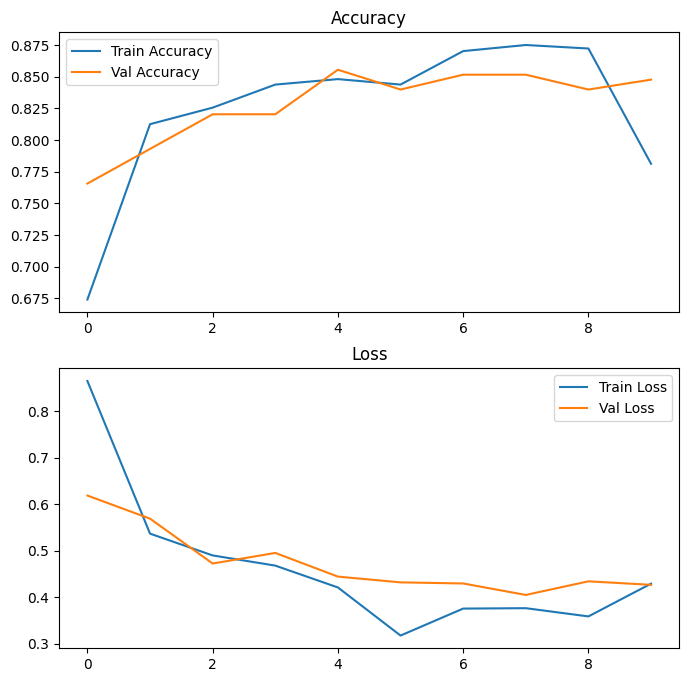

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(2,1,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

In [10]:
best_model = keras.models.load_model("best_model.h5")

In [13]:
from tensorflow.keras.preprocessing import image

labels = {0:'daisy', 1:'dandelion', 2:'rose', 3:'sunflower', 4:'tulip'}

def predict(img_path):
    img = image.load_img(img_path, target_size=(300,300))
    img_arr = image.img_to_array(img)/255.0
    plt.imshow(img_arr)
    plt.axis('off')
    plt.show()

    pred_vec = best_model.predict(img_arr[np.newaxis,...])[0]
    print("Predicted:", labels[np.argmax(pred_vec)], "| Confidence:", round(np.max(pred_vec)*100,2), "%")


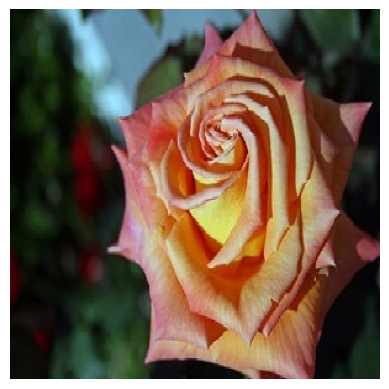

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted: rose | Confidence: 97.3 %


In [14]:
test_image = os.path.join(path, "test", os.listdir(os.path.join(path,"test"))[0])
predict(test_image)